# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science
## Homework 5 Parts 2 & 3: Vision Transformers & Kaggle Competition


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb


<hr style="height:2pt">

In [1]:
# RUN THIS CELL
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import time

SEED = 109

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-05-03 09:21:49.703711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-03 09:21:49.703748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-03 09:21:49.748198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 09:21:49.803434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should includelabels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes).
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

<a id="contents"></a>

# Notebook Contents

- [**PART 2 [40 pts]: Vison Transformer from Scratch**](#part2)
- [**PART 3 [10 pts]: Kaggle Competition**](#part3)

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">
    
# **PART 2: Vision Transformer from Scratch (40 points)**

Vision Transformers (ViTs) (for more details, see the original paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)) represent a groundbreaking approach in computer vision by adapting the Transformer architecture, originally designed for natural language processing, to image recognition tasks. The key idea is to split an image into a sequence of patches, treat these patches as tokens (much like words in a sentence), and process them with Transformer models. This paradigm shift has enabled ViTs to achieve state-of-the-art performance on various tasks.

In this part of the homework, we will implement a Vision Transformer (ViT) from scratch using TensorFlow. When fine-grained control over the operations in your model is needed, standard Keras layers might not be flexible enough. Creating custom layers, on the other hand, allows you to directly manage each operation within the layer. This not only enables experimentation with novel ideas but also allows you to tailor the model's behavior to its specific requirements. We will build our model using custom layers and train it on a classification task.


---

#### Creating a custom layer

TensorFlow's design specifies that all custom layers should inherit from `tf.keras.layers.Layer` to ensure they integrate seamlessly into its ecosystem (e.g., automatic differentiation, weight management). Inheritance is a fundamental concept in object-oriented programming (OOP) that allows a class (the child or subclass) to inherit attributes and methods from another class (the parent or superclass).


There are **two essential methods** you must implement when creating a custom layer:

1. **Constructor (`__init__`)**  
   - **Purpose:** Sets up the layer.
   - **What to Do:**  
     - Inherit from `tf.keras.layers.Layer` by calling `super().__init__()` or `super(class_name, self).__init__()`.
     - Initialize any trainable parameters or sub-layers.

2. **`call`**  
   - **Purpose:** Defines the forward pass (i.e., how inputs are transformed into outputs).
   - **What to Do:**  
     - Implement the layer’s logic. Whatever computation you need (for example, an element-wise operation) should be written in this method.
     - This method is automatically invoked during model training and inference.


**Example**
```python
import tensorflow as tf

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense3 = tf.keras.layers.Dense(hidden_dim)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = x + inputs
        return x
```

**What Happens in __init__:**
- We call `super(ResidualBlock, self).__init__()` to inherit from `tf.keras.layers.Layer`.
- We initialize three Dense layers `dense1`, `dense2` and `dense3`, using ReLU activation in the first two, and linear in the last one.

**What Happens in call:**
- The `call()` method passes the input through the three Dense layers sequentially
- a skip connection adds the original input to the output of the seuqnece of Dense layers.

</div>

## The Quick, Draw! Dataset 

For this problem, we will be working with a modified version of the [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset), which is a large database of 50 million drawings across 345 categories, collected from players of the game [Quick, Draw!](https://quickdraw.withgoogle.com/).

For this homework, we will simplify the problem by using only 306,000 images across 24 different classes for training (this includes the data you will use for validation) and a test set of 54,000 images.


<a id="part2data"></a>

## Downloading the Data Files


**The required `train.csv` file is available on [the "Data" tab of the CS1090B HW5 Kaggle Competition website](https://www.kaggle.com/t/e067286be2c54c078434793659326610). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**


- `train.csv` is our training dataset and the `label` column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.  `train.csv` has 306,000 samples. This is the only file needed for this part of the homework.

## The Quick, Draw! Dataset 

[Return to contents](#contents)


![](img/quickdrawpreview.jpg)



For this problem, we will be working with a modified version of the [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset), which is a large database of 50 million drawings across 345 categories, collected from players of the game [Quick, Draw!](https://quickdraw.withgoogle.com/).

For this homework, we will simplify the problem by using only 306,000 images across 24 different classes for training (this includes the data you will use for validation) and a test set of 54,000 images.


<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**The required `train.csv` and `test.csv` data files are available on [the "Data" tab of the CS1090B HW5 Kaggle Competition website](https://www.kaggle.com/t/e067286be2c54c078434793659326610). (DO NOT USE DATA FROM ANY OTHER SOURCE!)** Also please check the overview section for important notes [https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview)

Here's a brief description of the data files:

- `train.csv` is our training dataset and the `label` column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.  `train.csv` has 306,000 samples.

- `test.csv` file mirrors the structure of the `train.csv` file **without** the class label column. We have added another column `id`. `id` is a unique identifier for each sample in the test set. This ID is crucial for mapping your model's predictions back to the corresponding samples when submitting your results to Kaggle. `test.csv` has 54,000 samples. 


In [4]:
# import os
# import shutil

# # Move kaggle.json to the right location
# shutil.move("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

# # Set permissions
# os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [5]:
# import os
# import shutil

# kaggle_config_dir = "/shared/home/zas071/.config/kaggle"
# os.makedirs(kaggle_config_dir, exist_ok=True)
# shutil.move("kaggle.json", os.path.join(kaggle_config_dir, "kaggle.json"))


In [6]:
# !kaggle competitions download -c cs-1090-b-hw-5-contest-2025
# !unzip cs-1090-b-hw-5-contest-2025.zip -d dataset/


In [7]:
# import json
# with open("kaggle.json", "r") as f:
#     kaggle_creds = json.load(f)

# print("Username:", kaggle_creds["username"])
# print("API Key:", kaggle_creds["key"])

In [8]:
# import os
# os.environ['KAGGLE_USERNAME'] = 'zsardisantos'
# os.environ['KAGGLE_KEY'] = '37ce09733594b45f3b4796a077c6dd78'
# !kaggle competitions download -c cs-1090-b-hw-5-contest-2025
# !unzip cs-1090-b-hw-5-contest-2025.zip

In [9]:
# def load_data_from_csv(data_file):
#     """Load and preprocess data from CSV file"""
#     df = pd.read_csv(data_file)
#     classes = sorted(df['label'].astype(str).unique().tolist())

#     # classes = sorted(df['label'].unique().tolist())
    
#     label_to_id = {label: idx for idx, label in enumerate(classes)}
#     X = df.drop('label', axis=1).values.astype('uint8')
#     y = df['label'].map(label_to_id).values 
    
#     # Normalize pixel values to [0, 1]
#     X = X.astype('float32') / 255.0
#     X = X.reshape(-1, 28, 28, 1)
    
#     return df, X, y, classes, label_to_id  

# # Load and preprocess the data
# data_file = "train.csv"
# df, X, y, classes, label_to_id = load_data_from_csv(data_file) 

In [10]:
def load_data_from_csv(data_file):
    """Load and preprocess data from CSV file"""
    df = pd.read_csv(data_file)

    # Clean pixel data
    X_raw = df.drop('label', axis=1)

    # Force numeric, coerce errors into NaNs
    X_raw = X_raw.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any NaNs
    df_clean = pd.concat([X_raw, df['label']], axis=1).dropna()

    # Get label column cleanly
    df_clean['label'] = df_clean['label'].astype(str)
    classes = sorted(df_clean['label'].unique().tolist())
    label_to_id = {label: idx for idx, label in enumerate(classes)}

    # Final features and labels
    X = df_clean.drop('label', axis=1).values.astype('float32') / 255.0
    y = df_clean['label'].map(label_to_id).astype('int32').values

    # Reshape image
    X = X.reshape(-1, 28, 28, 1)

    return df_clean, X, y, classes, label_to_id


In [11]:
data_file = "train.csv"
df, X, y, classes, label_to_id = load_data_from_csv(data_file) 
print(df.dtypes)
print(df.isnull().sum().sum())  # Total number of NaNs


0         int64
1         int64
2         int64
3         int64
4         int64
          ...  
780       int64
781       int64
782       int64
783       int64
label    object
Length: 785, dtype: object
0


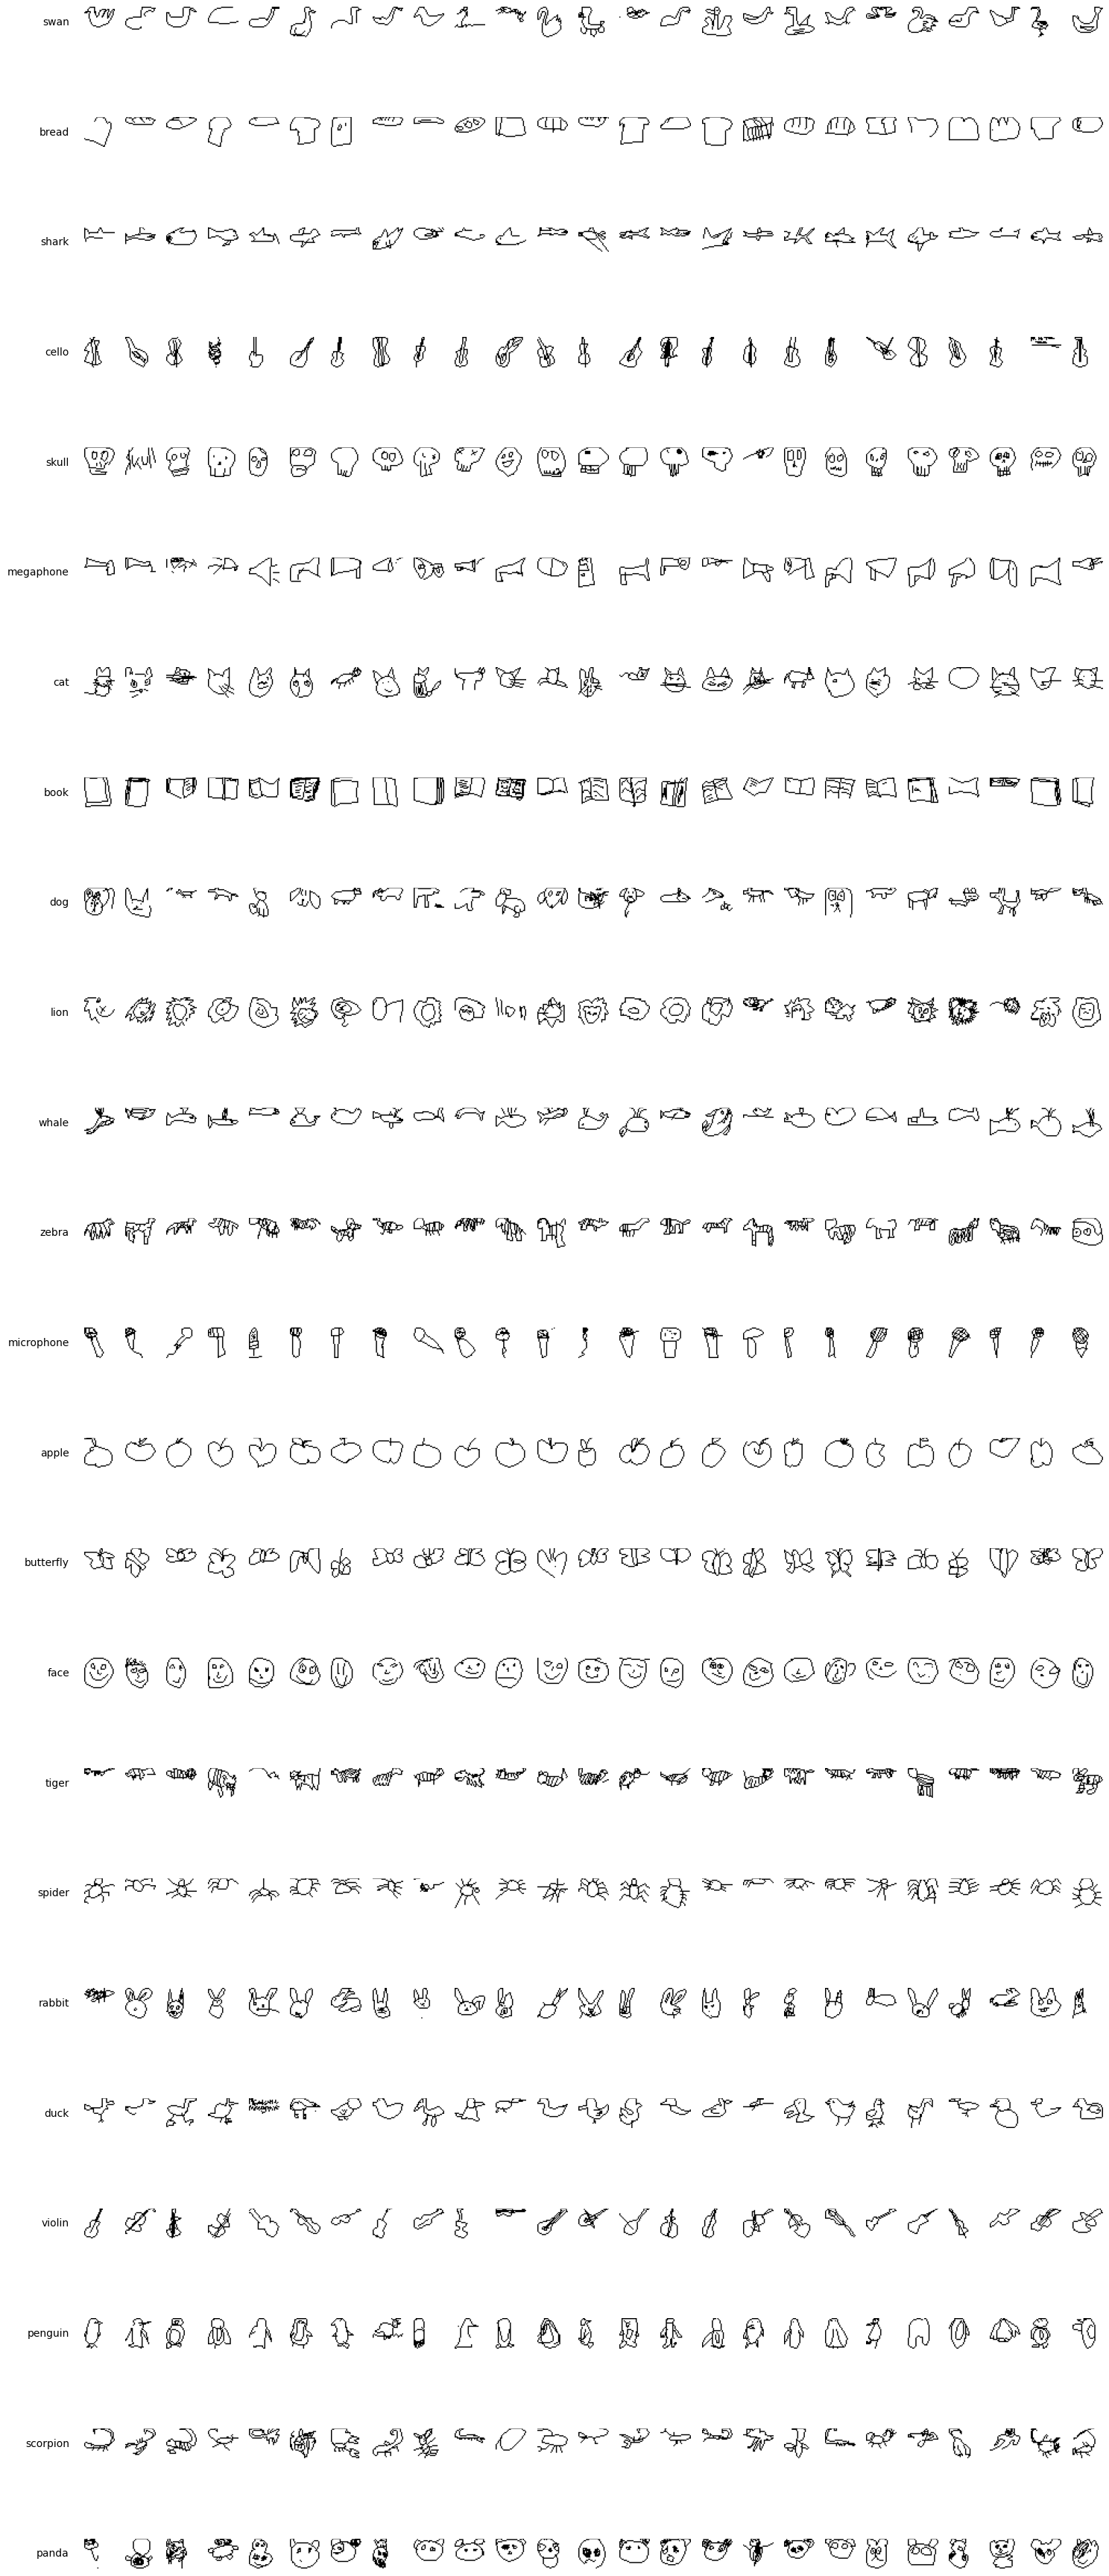

In [12]:
def plot_image_grid(df, classes, rows=5, cols=5):
    """
    Plot a grid of images for each class from the CSV data
    
    Args:
        df: DataFrame containing the image data and labels
        classes: List of class names
        rows: Number of rows in the grid (default 5)
        cols: Number of columns in the grid (default 5)
    """
    # Calculate figure size with reduced height per class
    fig_height = len(classes) * 1.5  
    fig = plt.figure(figsize=(15, fig_height))
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.1)
    
    for idx, class_name in enumerate(classes):
        class_samples = df[df['label'] == class_name].iloc[:rows*cols]
        
        for i in range(rows*cols):
            if i < len(class_samples):
                # Get image data, convert to float32 and normalize to [0,1]
                img_data = class_samples.iloc[i].drop(['label']).values.astype('float32') / 255.0
                img_data = img_data.reshape(28, 28)
                
                # Create subplot
                ax = plt.subplot(len(classes), rows*cols, idx*(rows*cols) + i + 1)
                plt.imshow(img_data, cmap='gray')
                plt.axis('off')
                
                # Add class label to the first image of each row
                if i == 0:
                    ax.text(-0.5, 0.5, class_name, rotation=0, 
                           ha='right', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

plot_image_grid(df, df.label.unique())

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">
    
#### Q2.1 Single-Head Self Attention

We will build each component of ViT separetely and combine everything in the `VisionTransformer` class. But let's start by implementing self-attention using a custom layer. Define a `SingleHeadAttention` class with the following:


**In the `__init__` method** fill in the blanks to initialize:
   - `W_query`: A dense layer mapping inputs to tensors with dimension `hidden_dim`
   - `W_key`: A dense layer mapping inputs to tensors with dimension `hidden_dim`
   - `W_value`: A dense layer mapping inputs to tensors with dimension `hidden_dim`
   - `hidden_dim`: The dimension of the projected tensors.

**In the `call` method you have to** compute the attention output. As you can recall form the "Attention Is All You Need" paper. Given an input tensor with shape `(batch_size, seq_length, input_dim)`, a Single-Head Self Attention layer performs the following operations:
   1. **Linear Projections**: Project the input into queries, keys, and values using learned weight matrices:
      $$Q = \text{inputs} \cdot W_{\text{query}}$$
      $$K = \text{inputs} \cdot W_{\text{key}}$$
      $$V = \text{inputs} \cdot W_{\text{value}}$$
      
      Where each projection transforms from `input_dim` to `hidden_dim`.

   2. **Scaled Dot-Product Attention**: Compute attention scores:
      $$\text{attention\_scores} = \frac{Q \cdot K^T}{\sqrt{\text{hidden\_dim}}}$$
      $$\text{attention\_weights} = \text{softmax}(\text{attention\_scores})$$
      $$\text{attention\_output} = \text{attention\_weights} \cdot V$$


**NOTE**: TensorFlow’s Dense layers perform “lazy” weight initialization – meaning that the layer’s weights aren’t created until the first time the layer is called (when the input shape is known). Therefore, you do not need to know `input_dim` when creating the layer, this will be defined by the input shape, when given to the model.

</div>

In [13]:
class SingleHeadAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):

# In the __init__ method fill in the blanks to initialize:
# W_query: A dense layer mapping inputs to tensors with dimension hidden_dim
# W_key: A dense layer mapping inputs to tensors with dimension hidden_dim
# W_value: A dense layer mapping inputs to tensors with dimension hidden_dim
# hidden_dim: The dimension of the projected tensors.
        """
        Single-head attention layer.
        
        Args:
            hidden_dim: Dimensionality for queries, keys, and values.
        """
        #these are linear projections of the word embeddings to new embeddings
        super(SingleHeadAttention, self).__init__()
        #save layers as attributes 
        self.hidden_dim = hidden_dim
        self.W_query = tf.keras.layers.Dense(hidden_dim)
        self.W_key = tf.keras.layers.Dense(hidden_dim)
        self.W_value = tf.keras.layers.Dense(hidden_dim)
        
        # your code

    def call(self, inputs):
        #deal w/ tf attributes inside the function so tensorflow can easily track gradients. essentially, just sticking
        #with tf attributes and tf library makes the training process smoother. 
        """
        Forward pass for single-head attention.
        
        Args:
            inputs: Tensor of shape (batch_size, seq_length, input_dim).
            
        Returns:
            attention_output: Attention output of shape (batch_size, seq_length, hidden_dim).
        """
        query = self.W_query(inputs)
        key = self.W_key(inputs)
        value = self.W_value(inputs)

        #attention_score = Q*K.T / sqrt(hidden_dim)
        #first have to do tensorflow matmul for numerator
        attention_score_numerator = tf.matmul(query, key, transpose_b = True)

        #  root_hid_dim = tf.cast(tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32)), tf.float32) # ChatGPT helped with this function as I didn't want to import the math library 
        # attention_scores = attention_scores / root_hid_dim
        
        #then compute full fraction which will give the attention matrix. 
        attention_score = (attention_score_numerator)/tf.cast(tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32)), tf.float32)
        #attention_weights = softmax(attention_score)
                # attention_weights = tf.nn.softmax(attention_scores, axis = -1)
        attention_weights = tf.nn.softmax(attention_score, axis=-1)
        attention_output = tf.matmul(attention_weights,value)
        return attention_output
        # your code here


#### Test 1: `SingleHeadAttention` implementation

In [14]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
input_dim = 64
hidden_dim = 32

# Create random input
inputs = tf.random.normal((batch_size, seq_length, input_dim))

attention = SingleHeadAttention(hidden_dim=hidden_dim)

# Forward pass: note that attention(inputs) is equivalent to attention.call(inputs)
attention_output = attention(inputs)

expected_output_shape = (batch_size, seq_length, hidden_dim)

assert attention_output.shape == expected_output_shape, \
    f"Output shape mismatch: got {attention_output.shape}, expected {expected_output_shape}"

print(f"SingleHeadAttention output shape: {attention_output.shape}")

2025-05-03 09:22:54.727448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:3c:00.0, compute capability: 8.9


SingleHeadAttention output shape: (2, 8, 32)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.2 Multi-Head Attention Layer

The `MultiHeadAttentionLayer` implements multi-head self-attention by processing several single-head attention operations in parallel and then combining their outputs. Given an input tensor with shape `(batch_size, seq_length, input_dim)`, follow these instructions:

**In the `__init__` method, you need to:**

- **Initialize the number of heads and single-head attention layers:**
  - Create a list of attention heads. Each head is an instance of your single-head attention layer, configured with a projection output dimensionality of `head_dim`.  
  - For each head $i$ (with $i = 1, \dots, \text{num\_heads}$), the head computes  
    $$
    \text{attn\_output}_i = \text{SingleHeadAttention}_i(\text{inputs})
    $$
    where each $\text{attn\_output}_i$ has shape `(batch_size, seq_length, head_dim)`.

- **Initialize the output projection layer:**
  - Define a Dense layer that projects the concatenated outputs back to the original input dimension (`input_dim`).  
  - Once you have concatenated the outputs from all heads, you obtain a tensor of shape `(batch_size, seq_length, head_dim x num_heads)` and the output projection layer maps this tensor to shape `(batch_size, seq_length, input_dim)`.

**In the `call` method, you need to:**

1. **Process each attention head:**
   - Iterate over the list of single-head attention layers and pass the input tensor through each one. This produces, for each head $i$, an output $\text{attn\_output}_i$ of shape `(batch_size, seq_length, head_dim)`.

2. **Concatenate the outputs:**
   - Concatenate all the $\text{attn\_output}_i$ tensors along the last (feature) axis:
     $$
     \text{concatenated} = \text{concat}\left(\left[\text{attn\_output}_1,\, \text{attn\_output}_2,\, \dots,\, \text{attn\_output}_{\text{num\_heads}}\right]\right)
     $$
     This results in a tensor of shape `(batch_size, seq_length, head_dim × num_heads)`.

3. **Apply the output projection:**
   - Feed the concatenated tensor into the output projection Dense layer:
     $$
     \text{multihead\_output} = \text{output\_projection}(\text{concatenated})
     $$
     This yields the final output tensor with shape `(batch_size, seq_length, input_dim)`.

This process enables the model to attend to different subspaces of the input simultaneously, thereby capturing a richer representation of the data.

</div>


#### Q2.2 Multi-Head Attention Layer

The `MultiHeadAttentionLayer` implements multi-head self-attention by processing several single-head attention operations in parallel and then combining their outputs. Given an input tensor with shape `(batch_size, seq_length, input_dim)`, follow these instructions:

**In the `__init__` method, you need to:**

- **Initialize the number of heads and single-head attention layers:**
  - Create a list of attention heads. Each head is an instance of your single-head attention layer, configured with a projection output dimensionality of `head_dim`.  
  - For each head $i$ (with $i = 1, \dots, \text{num\_heads}$), the head computes  
    $$
    \text{attn\_output}_i = \text{SingleHeadAttention}_i(\text{inputs})
    $$
    where each $\text{attn\_output}_i$ has shape `(batch_size, seq_length, head_dim)`.

- **Initialize the output projection layer:**
  - Define a Dense layer that projects the concatenated outputs back to the original input dimension (`input_dim`).  
  - Once you have concatenated the outputs from all heads, you obtain a tensor of shape `(batch_size, seq_length, head_dim x num_heads)` and the output projection layer maps this tensor to shape `(batch_size, seq_length, input_dim)`.


In [15]:
#an instructor is a special method that creates and initializes an object
# def _init_(self,...)

#when I create an object like mha = MultiHeadAttentionLayer(input_dim=512,head_dim=64, num_heads = 8)
#Python calls _init_ to set up the new mha object
#the constructor sets up the interrnal components (like attention heads), the learnable parameters, and
#saves settings like num_heads and head_dim for later use 

#again, def __init__ just sets up the blueprint for different instances of classes later on. just sets up the structure. 
#call(self, inputs)  is where the real computation happens  - model sees real input data
#where we apply attention heads, etc

#on the topic of multi head attention, if we have 8 heads, we want to project into a smaller dimension
#this is because when we concatenate the 8 different sets of contextual embeddings,
#we get an explosion in computation if we do not project into a smaller dimension.

#so we shrink each head. if 8 heads and input dimension of 512, we have output dimension of 512/8 = 64 for each head

#what differentiates each attention head in multiheadattention is that each Q K V matrix has different weights, 
#b/c they are initialized differently and trained differently during backpropagation.
#the heads specialize differently during training. 




class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, head_dim, num_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.input_dim = input_dim
        
        self.attention_heads = [
            SingleHeadAttention(head_dim) for _ in range(num_heads)
        ]
        
        self.output_projection = tf.keras.layers.Dense(self.input_dim)

        #the constructor needs head_dim as an input
        #because each indiviudal attention head must project the  input embeddings into smaller size
        #head dim 
            
      
        # self.output_projection = tf.keras.layers.Dense(self.input_dim)
        
        
        # your code here

    def call(self, inputs):
        #apply each attention head separately
        head_outputs = []
        for head in self.attention_heads:
            #each head returns (batch_size, seq_length, head_dim)
            head_output = head(inputs)
            head_outputs.append(head_output)
            
        # Step 2: concatenate all head outputs along the last axis
        concatenated = tf.concat(head_outputs, axis=-1)  # shape: (batch_size, seq_length, num_heads * head_dim)

        # Step 3: project concatenated output back to input_dim
        output = self.output_projection(concatenated)  # shape: (batch_size, seq_length, input_dim)
        # print("  ↪ input shape:", inputs.shape)
        # print("  ↪ concatenated heads shape:", concatenated.shape)
        # print("  ↪ projected output shape:", output.shape)
        return output
        """
        Forward pass for multi-head attention.
        
        Args:
            inputs: Tensor of shape (batch_size, seq_length, input_dim).
            
        Returns:
            multihead_output: Multi-head attention output of shape (batch_size, seq_length, input_dim).
        """
        # your code here

#### Test 2: `MultiHeadAttentionLayer` implementation

In [16]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
# input_dim = 32 #changed to 32 from 64 
input_dim = 64
head_dim = 16
num_heads = 4

# Create random input tensor
inputs = tf.random.normal((batch_size, seq_length, input_dim))

multihead_attention = MultiHeadAttentionLayer(input_dim=input_dim, head_dim=head_dim, num_heads=num_heads)

attention_output = multihead_attention(inputs)

expected_output_shape = (batch_size, seq_length, input_dim)

assert attention_output.shape == expected_output_shape, (
    f"Output shape mismatch: got {attention_output.shape}, expected {expected_output_shape}"
)

print(f"Multi-head attention output shape: {attention_output.shape}")

Multi-head attention output shape: (2, 8, 64)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.3 Transformer Encoder Block

Given an input tensor `inputs` of shape `(batch_size, seq_length, embed_dim)` the `TransformerEncoderBlock` performs the following operations:

**In the `__init__` method, you need to:**

- **Initialize the Multi-Head Attention:**
  - Create a `MultiHeadAttentionLayer` that processes the inputs to produce `attn_output = MultiHeadAttentionLayer(inputs)`

- **Initialize the Feed-Forward Network:**
  - Build a Sequential block consisting of:
    - `LayerNormalization` with `epsilon = 1e-5`
    - A `Dense` layer with `GELU` activation mapping to `feedforward_dim` units
    - A `Dropout` layer with `ffn_dropout_rate`.
    - A `Dense` layer mapping back to `embed_dim`
    - A `Dropout` layer with `ffn_dropout_rate`.
  This block, when applied to an input \(x\), computes:
    $$
    \text{ffn\_output} = \text{FFN}(x)
    $$
    yielding a tensor with shape `(batch_size, seq_length, embed_dim)`.

**In the `call` method, you need to:**

1. **Compute the Multi-Head Attention:**
   - Apply layer norm to `inputs` with `epsilon = 1e-5`:
     $$
     \text{normalized\_inputs} = \text{LayerNormalization}(\text{inputs})
     $$
   - Apply the multi-head attention layer:
     $$
     \text{attn\_output} = \text{MultiHeadAttentionLayer}(\text{normalized\_inputs})
     $$
   - Apply `Dropout` with rate `attn_dropout_rate`:
     $$
     \text{attn\_output} = \text{Dropout}(\text{attn\_output})
     $$
   - Add a residual connection:
     $$
     x = \text{inputs} + \text{attn\_output}
     $$

2. **Process through the Feed-Forward Network:**
   - Compute the feed-forward output:
     $$
     \text{ffn\_output} = \text{FFN}(x)
     $$
   - Apply a second residual connection:
     $$
     \text{output} = x + \text{ffn\_output}
     $$

The final output tensor `output` of shape `(batch_size, seq_length, embed_dim)` incorporates both self-attention and feed-forward processing with residual connections.

</div>



**In the `__init__` method, you need to:**

- **Initialize the Multi-Head Attention:**
  - Create a `MultiHeadAttentionLayer` that processes the inputs to produce `attn_output = MultiHeadAttentionLayer(inputs)`

**Initialize the Feed-Forward Network:**
  - Build a Sequential block consisting of:
    - `LayerNormalization` with `epsilon = 1e-5`
    - A `Dense` layer with `GELU` activation mapping to `feedforward_dim` units
    - A `Dropout` layer with `ffn_dropout_rate`.
    - A `Dense` layer mapping back to `embed_dim`
    - A `Dropout` layer with `ffn_dropout_rate`.
  This block, when applied to an input \(x\), computes:
    $$
    \text{ffn\_output} = \text{FFN}(x)
    $$
    yielding a tensor with shape `(batch_size, seq_length, embed_dim)`.

## Big Picture

input = token embeddings (shape = batch_size, seq_length, embed_dim)

(input --> transformerencoderblock --> output)

output = contextualized token embeddings (shape = batch_size, seq_length, embed_dim)

Inside the TransformerEncoderBlock
1. MHA (contextualized embeddings)
2. Residual Connection (prevents vanishing gradient and allows model to keep raw token information + contextual information together)
3. FFNN - detect deeper patterns after attention. Without the FFN, attention alone would not have enough modeling power to build very rich token-level representations. FFN adds depth and expressivity token-by-token.


Flow of the Transformer Encoder Block

1. Raw input embeddings
2. LayerNorm
3. MHA
4. Dropout + Residual Connection
5. FFNN
6. Dropout + Residual Connection
7. Output

In [17]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self,
                 embed_dim,
                 attention_dim,
                 feedforward_dim,
                 num_heads,
                 ffn_dropout_rate=0.1,
                 attn_dropout_rate=0.1,
                 epsilon=1e-5):
        super(TransformerEncoderBlock, self).__init__()
        
        #multihead attention layer  - HOW can we pass in these arguments if they aren't arguments for this constructor
        #mha learns different contextual relations between embeddings. semantic structure.
        self.mha = MultiHeadAttentionLayer(input_dim=embed_dim, head_dim=attention_dim, num_heads=num_heads)
        
        #layernorm from inputs to attention matrix
        self.attn_layernorm = tf.keras.layers.LayerNormalization(epsilon=epsilon)
        #dropout after attention to regularize  and prevent overfitting 
        self.attn_dropout = tf.keras.layers.Dropout(attn_dropout_rate)
        #we have ffnn to further process per token info and strengthen feature transformations 
        # self.ffn = tf.keras.Sequential([
        #     tf.keras.layers.LayerNormalization(epsilon=epsilon),
        #     tf.keras.layers.Dense(feedforward_dim, activation='gelu'),
        #     tf.keras.layers.Dropout(ffn_dropout_rate)
        
         # 4. Feed-Forward Network (FFN)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(epsilon=epsilon),
            tf.keras.layers.Dense(feedforward_dim, activation='gelu'),
            tf.keras.layers.Dropout(ffn_dropout_rate),
            tf.keras.layers.Dense(embed_dim),
            tf.keras.layers.Dropout(ffn_dropout_rate)
        ])

                                       
# tf.keras.layers.Dense(hidden_dim, activation = 'linear')
        
        """
        A single Transformer encoder block with multi-head attention and feed-forward network.
        
        Args:
            embed_dim: Dimensionality of the input embeddings.
            attention_dim: Dimensionality used in each attention head.
            feedforward_dim: Dimensionality of the intermediate feed-forward layer.
            num_heads: Number of attention heads.
        """
        
        
        
        
        # your code here

    def call(self, inputs, training=False):
        #normalize the inputs  into transformer encoder
        normalized_inputs = self.attn_layernorm(inputs)

        #apply multi head attention
        attn_output = self.mha(normalized_inputs)
        attn_output = self.attn_dropout(attn_output, training = training)

        # print("inputs dtype:", inputs.dtype)
        # print("attn_output dtype:", attn_output.dtype)
         # 3. Residual connection after attention
        #we add residual connection 
        x = inputs + attn_output
        # x = inputs + attn_output
        
        # 4. Feed-forward network
        # pass training flag for dropout
        ffn_output = self.ffn(x,training=training)
          
        # print("inputs shape:", inputs.shape)
        # print("attn_output shape:", attn_output.shape)
        # 5. Final residual connection
        output = x + ffn_output
        return output
        
        """
        Forward pass for a single Transformer encoder block.
        
        Args:
            inputs: Tensor of shape (batch_size, seq_length, embed_dim).
        
        Returns:
            output: Output tensor of shape (batch_size, seq_length, embed_dim).
        """
        # your code here


#### Test 3: `TransformerEncoderBlock` implementation

In [18]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
embed_dim = 32
attention_dim = 16
feedforward_dim = 64
num_heads = 4

# Create a random input tensor
inputs = tf.random.normal((batch_size, seq_length, embed_dim))

encoder_block = TransformerEncoderBlock(
    embed_dim=embed_dim,
    attention_dim=attention_dim,
    feedforward_dim=feedforward_dim,
    num_heads=num_heads)

output = encoder_block(inputs)

expected_output_shape = (batch_size, seq_length, embed_dim)

assert output.shape == expected_output_shape, (
    f"Output shape mismatch: got {output.shape}, expected {expected_output_shape}"
)

print(f"TransformerEncoderBlock output shape: {output.shape}")

TransformerEncoderBlock output shape: (2, 8, 32)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.4 Transformer Encoder

Given an input tensor `inputs` of shape `(batch_size, seq_length, embed_dim)`, the `TransformerEncoder` applies a stack of encoder blocks sequentially. 

**In the `__init__` method, you need to:**

- **Initialize the Encoder Blocks:**
  - Create a list of `num_blocks` instances of `TransformerEncoderBlock`, each instantiated with parameters `embed_dim`, `attention_dim`, `feedforward_dim`, and `num_heads`.

**In the `call` method, you need to:**

1. **Initialize the Representation:**
   - Set
     $$
     x_0 = \text{inputs} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_length} \times \text{embed\_dim}}.
     $$

2. **Apply Each Encoder Block:**
   - For each encoder block $i$, with $i = 1, 2, \dots, \text{num\_blocks}$:
     $$
     x_i = \text{TransformerEncoderBlock}_i\big(x_{i-1}\big).
     $$
     
3. **Return the Final Output:**
   - The final output is 
     $$
     \text{output} = x_{\text{num\_blocks}} \in \mathbb{R}^{\text{batch\_size} \times \text{seq\_length} \times \text{embed\_dim}}.
     $$

This stacking operation iteratively refines the input representation through multiple encoder blocks.

</div>



**In the `__init__` method, you need to:**

- **Initialize the Encoder Blocks:**
  - Create a list of `num_blocks` instances of `TransformerEncoderBlock`, each instantiated with parameters `embed_dim`, `attention_dim`, `feedforward_dim`, and `num_heads`.

In [19]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, attention_dim, feedforward_dim, num_heads, num_blocks):
        
        """
        A stack of Transformer encoder blocks.
        """
        
        super(TransformerEncoder, self).__init__()
        # BEGIN SOLUTION
        #self = current instance of class 
        #ok so I want create list of num blocks instances of TransformerEncoderBlock,
    #instantiated w/ params embed dim attention dim feedwordard dim and num heads
        #the list encoder_blocks belongs to this class, it is not a local variable, so
        #thats why we have self.encoder_blocks, to show the list belongs to the class
        
        self.encoder_blocks = [
            TransformerEncoderBlock(
                embed_dim=embed_dim,
                attention_dim=attention_dim,
                feedforward_dim=feedforward_dim,
                num_heads=num_heads)
            #create list of range num_blocks
            for _ in range(num_blocks)
        ]
         

        # END SOLUTION

    def call(self, inputs):
        #so in the call method I must set x = inputs (initialize the representation)
        #then apply each encoder block to each input
        #then return the final output 
        x = inputs
        #for each transformer block in the list 
        for block in self.encoder_blocks:
            x = block(x)
        return x 
        

#### Test 4: `TransformerEncoder` implementation

In [20]:
# Run the following test to help debug your implementation so far

batch_size = 2
seq_length = 8
embed_dim = 32
attention_dim = 16
feedforward_dim = 64
num_heads = 4
num_blocks = 3

# Create a random input tensor of shape
inputs = tf.random.normal((batch_size, seq_length, embed_dim))

encoder = TransformerEncoder(embed_dim, attention_dim, feedforward_dim, num_heads, num_blocks)

output = encoder(inputs)

expected_output_shape = (batch_size, seq_length, embed_dim)

assert output.shape == expected_output_shape, (
    f"Output shape mismatch: got {output.shape}, expected {expected_output_shape}"
)

print(f"TransformerEncoder output shape: {output.shape}")

TransformerEncoder output shape: (2, 8, 32)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.5 Patch Embedding

The `PatchEmbedding` layer converts an input image into a sequence of patch embeddings. Given an image tensor with shape `(batch_size, image_size, image_size, input_channels)`, the layer performs the following steps:

**In the `__init__` method, you need to:**

- **Store Relevant Attributes:**  
  - Save `image_size`, `input_channels`, `patch_size`, and `num_patches` as class attributes.
- **Compute Number of Patches:**  
  - Calculate `num_patches` as `(image_size // patch_size) ** 2`.
- **Initialize the Projection:**  
  - Create a Dense layer (`self.projection`) that will map the flattened patch vector to a vector of dimension `embed_dim`.

**In the `call` method, you need to:**

1. **Extract Patches:**  
   - Use `tf.image.extract_patches` to split the input image into non-overlapping patches. The patches are extracted with:
     - `sizes = [1, patch_size, patch_size, 1]`
     - `strides = [1, patch_size, patch_size, 1]`
     - `rates = [1, 1, 1, 1]`
     - `padding = "VALID"`
   - This produces a tensor of shape `(batch_size, image_size/patch_size, image_size/patch_size, patch_area * input_channels)`.

2. **Reshape the Patches:**  
   - Flatten the spatial dimensions to convert the patches tensor to shape `(batch_size, num_patches, patch_flat_dim)`, where:
     - `patch_flat_dim = patch_size * patch_size * input_channels`.
   - **Note**: You might find the function `tf.reshape()` useful in this case.

3. **Project the Patches:**  
   - Pass the flattened patches through the `Dense` projection layer to obtain the final patch embeddings.
   - The output has shape `(batch_size, num_patches, embed_dim)`.

This layer effectively transforms each patch (a flattened vector of pixel values) into a learned embedding, serving as the input to subsequent Transformer blocks.

</div>


1. **Extract Patches:**  
   - Use `tf.image.extract_patches` to split the input image into non-overlapping patches. The patches are extracted with:
     - `sizes = [1, patch_size, patch_size, 1]`
     - `strides = [1, patch_size, patch_size, 1]`
     - `rates = [1, 1, 1, 1]`
     - `padding = "VALID"`
   - This produces a tensor of shape `(batch_size, image_size/patch_size, image_size/patch_size, patch_area * input_channels)`.

2. **Reshape the Patches:**  
   - Flatten the spatial dimensions to convert the patches tensor to shape `(batch_size, num_patches, patch_flat_dim)`, where:
     - `patch_flat_dim = patch_size * patch_size * input_channels`.
   - **Note**: You might find the function `tf.reshape()` useful in this case.

3. **Project the Patches:**  
   - Pass the flattened patches through the `Dense` projection layer to obtain the final patch embeddings.
   - The output has shape `(batch_size, num_patches, embed_dim)`

In [21]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, image_size, patch_size, input_channels, embed_dim):
        """
        Converts an image into a sequence of patch embeddings.
        """
        super(PatchEmbedding, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.input_channels = input_channels
        self.num_patches = (image_size//patch_size)**2
        #project the image patches into vector representations of embed dim dimension
        self.projection = tf.keras.layers.Dense(embed_dim)
        
    # def call(self, images):
    #     #split img into patches using tf.image.extract_patches. this gives 4d tensor
    #     patches = tf.image.extract_patches(images = images, 
    #                                      sizes = [1, patch_size, patch_size, 1], 
    #                                      strides = [1, patch_size, patch_size, 1],
    #                                      rates = [1, 1, 1, 1],
    #                                      padding = "VALID")
        
    #     #reshape patches into 3d tensor [batch_size, num_patches, patch)dim)
    #     batch_size = tf.shape(images)[0]
    #     # num_patches = self.num_patches
    #     patch_flat_dim = self.patch_size * self.patch_size * self.input_channels
    #     # patch_flat_dim = (self.patch_size**2)*self.input_channels
    #     num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
    #     patches = tf.reshape(patches, [batch_size, num_patches,patch_flat_dim])

    #     #project the patches
    #     patch_embeddings = self.projection(patches)
    #     return patch_embeddings

    # def call(self, images):
    #     # Step 1: Extract patches (using tf.image.extract_patches)
    #     patches = tf.image.extract_patches(
    #         images=images,
    #         sizes=[1, self.patch_size, self.patch_size, 1],
    #         strides=[1, self.patch_size, self.patch_size, 1],
    #         rates=[1, 1, 1, 1],
    #         padding="VALID"
    #     )  # shape: (batch_size, num_patches_h, num_patches_w, patch_flat_dim)
    
    #     # Step 2: Compute shapes dynamically
    #     batch_size = tf.shape(images)[0]
    #     patch_flat_dim = self.patch_size * self.patch_size * self.input_channels
    #     num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]  # dynamic patch count
    
    #     # Step 3: Flatten the spatial dimensions into one
    #     # patches = tf.reshape(patches, [batch_size, num_patches, patch_flat_dim])
    #     patches = tf.reshape(patches, (batch_size, self.num_patches, patch_flat_dim))
    
    #     # Step 4: Project each flattened patch to the embedding dimension
    #     patch_embeddings = self.projection(patches)  # shape: (batch_size, num_patches, embed_dim)
    
    #     return patch_embeddings
    def call(self, images):
        # Extract patches
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )  # shape: (batch_size, num_patches_h, num_patches_w, patch_flat_dim)
    
        # Dynamically compute patch counts
        batch_size = tf.shape(images)[0]
        patch_flat_dim = self.patch_size * self.patch_size * self.input_channels
    
        # ✅ Compute num_patches dynamically
        num_patches_h = tf.shape(patches)[1]
        num_patches_w = tf.shape(patches)[2]
        num_patches = num_patches_h * num_patches_w
    
        #(batch_size, num_patches, patch_flat_dim)
        patches = tf.reshape(patches, [batch_size, num_patches, patch_flat_dim])
    
        #project to embedded dimension
        patch_embeddings = self.projection(patches)  # shape: (batch_size, num_patches, embed_dim)
    
        return patch_embeddings


        # your code here


#### Test 5: `PatchEmbedding` implementation

In [22]:
# Run the following test to help debug your implementation so far 

batch_size = 2
image_size = 32
patch_size = 8
input_channels = 3
embed_dim = 64

num_patches = (image_size // patch_size) ** 2

# Create a random input tensor representing images
images = tf.random.normal((batch_size, image_size, image_size, input_channels))

patch_embedding = PatchEmbedding(
    image_size=image_size,
    patch_size=patch_size,
    input_channels=input_channels,
    embed_dim=embed_dim
)

output = patch_embedding(images)

expected_output_shape = (batch_size, num_patches, embed_dim)

assert output.shape == expected_output_shape, (
    f"Output shape mismatch: got {output.shape}, expected {expected_output_shape}"
)

print(f"PatchEmbedding output shape: {output.shape}")

PatchEmbedding output shape: (2, 16, 64)


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.6 Vision Transformer

The `VisionTransformer` model will put all these pieces together. To help a little bit, we filled the constructor for you. Given an input tensor with shape  `(batch_size, height, width, input_channels)` where `height = width = image_size`, the model operates as follows:

**In the `__init__` method:**

- **Determine Input Parameters:**
  - Extract `image_size` and `input_channels` from `input_size`.
- **Create the Patch Embedding Layer:**
  - The `PatchEmbedding` layer splits the image into non-overlapping patches and projects each patch to an embedding vector of dimension `embed_dim`.
  - The total number of patches is computed as `num_patches = (image_size // patch_size)^2`
- **Define Positional Embedding:**
  - Create a positional embedding using `tf.keras.layers.Embedding` with an input dimension equal to `num_patches` and an output dimension `embed_dim`.
- **Define a Learnable Class Token:**
  - Initialize a class token of shape `(1, 1, embed_dim)`, which is later broadcasted to every batch.
- **Instantiate the Transformer Encoder:**
  - Create a `TransformerEncoder` that contains `num_blocks` encoder blocks.  
    Each block applies multi-head attention and a feed-forward network (with their respective dropout, residual connections, and layer normalization) to process the input.
- **Define the Classification Head:**
  - Build a sequential model comprising a `LayerNormalization` (with `epsilon=1e-5`) followed by a Dense layer mapping to `num_classes`.

**In the `call` method, you need to:**

1. **Compute Patch Embeddings:**
   - Pass `images` through `self.patch_embedding` to obtain `patch_embeddings` of shape `(batch_size, num_patches, embed_dim)`
2. **Add Positional Embeddings:**
   - Generate a sequence of positions (of length `num_patches`) and map them through `self.position_embedding` to obtain positional embeddings:  
     `positional_embeddings` of shape `(1, num_patches, embed_dim)`
   - Add these positional embeddings to `patch_embeddings` elementwise.
3. **Prepend the Class Token:**
   - Broadcast the learnable class token to match the batch size, resulting in a tensor of shape `(batch_size, 1, embed_dim)`.
   - Concatenate this class token with the positional-enhanced patch embeddings along the sequence dimension, yielding:  
     `transformer_input` with shape `(batch_size, num_patches + 1, embed_dim)`
4. **Apply the Transformer Encoder:**
   - Pass `transformer_input` through `self.transformer_encoder` which outputs `encoder_output` with shape `(batch_size, num_patches + 1, embed_dim)`
5. **Classification:**
   - The classification head uses the embedding corresponding to the class token (index 0) to compute logits `logits`, with shape`(batch_size, num_classes)`

The model thus returns the `logits` that represent the class scores for each input image.

</div>



In [23]:
class VisionTransformer(tf.keras.Model):
    # We'll give you the init ;)
    #thx 
    def __init__(
        self,
        num_classes,
        patch_size,
        num_heads,
        num_blocks,
        embed_dim,
        attention_dim,
        feedforward_dim,
        input_size=(28,28,1)
    ):
        
        super(VisionTransformer, self).__init__()
        #instantiate image and the patch embeddings
        image_size = input_size[0]
        input_channels = input_size[-1]
        self.patch_embedding = PatchEmbedding(
            image_size, patch_size, input_channels, embed_dim
        )
        self.num_patches = (image_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Positional embedding for each patch
        #positional embedding via inherited embedding layer form tf library
        #takes as input the number of patches (not the patches themselves) 
        #and outputs embed dimension psoitional vectors
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=self.num_patches,
            output_dim=embed_dim
        )

        # Learnable class token used for classification
        #defining the cls token
        self.cls = self.add_weight(
            "cls",
            shape=(1, 1, embed_dim),
            initializer=tf.random_normal_initializer()
        )
        #here is our transformer encoder, multi head attention, num_blocks = num_blocks
        #we can import all of these b/c they are inherited from previous classes I think 
        self.transformer_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            attention_dim=attention_dim,
            feedforward_dim=feedforward_dim,
            num_heads=num_heads,
            num_blocks=num_blocks
        )

        # Classification head: LayerNorm -> Dense
        self.classification_head = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(epsilon=1e-5),
            tf.keras.layers.Dense(num_classes)
        ])

    def call(self, images):
        #forward pass, input image tensors output logits
        #1. compute patch embeddings iamges to patch embeddings
        batch_size = tf.shape(images)[0]
        # positions = tf.range(start=0, limit=self.num_patches, delta=1)
        patch_embeddings = self.patch_embedding(images)
        #2. add positional embeddings to patch embeddings 
        num_patches = self.num_patches 
        # num_patches = tf.shape(patch_embeddings)[1]
        
        # positions = tf.range(start=0, limit=num_patches, delta=1)
        positions = tf.range(num_patches)

        # tf.range(seq_length)[None, :] 
        
        positional_embeddings = self.position_embedding(positions)
        positional_embeddings = tf.expand_dims(positional_embeddings, axis=0)# shape: (1, num_patches, embed_dim)
        new_patch_embeddings = patch_embeddings + positional_embeddings

        #prepend class token
        # cls = self.cls(batch_size, 1, embed_dim)
        # cls_token = tf.broadcast_to(self.cls, [batch_size, 1, self.embed_dim])
        cls_token = tf.tile(self.cls,[batch_size,1,1])
        # shape: (batch_size, 1, embed_dim)
        #4 apply transformer encoder - we feed the concatenated cls token and patch embeddings into transfor
        transformer_input = tf.concat([cls_token, new_patch_embeddings], axis=1)
        #encoder_output is concatenated cls token and x post fed through the trransformer encoder
        encoder_output = self.transformer_encoder(transformer_input)
        #5 cls token classification logits
        #classification
        cls_output = encoder_output[:, 0]  # shape: (batch_size, embed_dim)
        logits = self.classification_head(cls_output)
        return logits 
        
        

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### 2.7 Model training and evaluation

##### Q2.7.1 Create data splits
   - Create train and validation splits from your dataset `(X, y)` using `train_test_split` with `test_size=0.1` and `random_state=109`.
   - Create the training and validation datasets using `tf.data.Dataset.from_tensor_slices()`, then batch them using a batch size of 512.

In [24]:
# your code here
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.1,random_state=109)

train_data = tf.data.Dataset.from_tensor_slices((train_x,train_y)).batch(512)
validation_data = tf.data.Dataset.from_tensor_slices((test_x,test_y)).batch(512)

# train_data = train_data.batch(512).prefetch(tf.data.AUTOTUNE)
# validation_data = validation_data.batch(512).prefetch(tf.data.AUTOTUNE)


2025-05-03 09:22:58.947605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 863654400 exceeds 10% of free system memory.
2025-05-03 09:22:59.404995: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 863654400 exceeds 10% of free system memory.


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">


##### Q2.7.2 Model training and evaluation 
   Create a `VisionTransformer` with the following configuration:
   - `num_classes = 24`
   - `patch_size = 4`
   - `num_heads = 8`
   - `num_blocks = 4`
   - `embed_dim = 64`
   - `attention_dim = 64`
   - `feedforward_dim = 128`

After instantiating your model, call the `build` method with an input shape of `(None, 28, 28, 1)` and show a summary of it.

In [21]:
# your code here
ViT = VisionTransformer(num_classes=24,
                                     patch_size = 4,
                                     num_heads = 8,
                                     num_blocks = 4,
                                     embed_dim = 64,
                                     attention_dim = 64,
                                     feedforward_dim = 128)


#build method, specific model w/ specific input 
ViT.build(input_shape=(None,28,28,1))

ViT.summary()


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding_1 (PatchEm  multiple                  1088      
 bedding)                                                        
                                                                 
 embedding (Embedding)       multiple                  3136      
                                                                 
 transformer_encoder_1 (Tra  multiple                  598016    
 nsformerEncoder)                                                
                                                                 
 sequential_8 (Sequential)   (None, 24)                1688      
                                                                 
Total params: 603992 (2.30 MB)
Trainable params: 603992 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

##### Q2.7.3 Model training

Train the model for 20 epochs using `Adam` with learning rate of 0.005, `SparseCategoricalCrossentropy` as loss function, and `accuracy` as metric.

In [22]:
# your code here
# optimizer='rmsprop',
#     loss=None,
#     metrics=None,

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
ViT.compile(optimizer = optimizer, loss= loss_fn, 
            metrics = ['accuracy'])

history = ViT.fit(train_data, validation_data = validation_data, epochs = 20, verbose = 1)

2025-05-01 21:56:49.069785: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 863654400 exceeds 10% of free system memory.


Epoch 1/20


2025-05-01 21:57:07.010889: I external/local_xla/xla/service/service.cc:168] XLA service 0x14b160d300d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-01 21:57:07.010932: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-05-01 21:57:07.015447: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-01 21:57:07.038074: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1746151027.103228   11615 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


538/538 [==============================] - 73s 83ms/step - loss: 2.0134 - accuracy: 0.3995 - val_loss: 1.3277 - val_accuracy: 0.5972
Epoch 2/20
538/538 [==============================] - 43s 81ms/step - loss: 1.2041 - accuracy: 0.6383 - val_loss: 1.0943 - val_accuracy: 0.6709
Epoch 3/20
538/538 [==============================] - 44s 81ms/step - loss: 1.0298 - accuracy: 0.6901 - val_loss: 0.9980 - val_accuracy: 0.6993
Epoch 4/20
538/538 [==============================] - 44s 81ms/step - loss: 0.9475 - accuracy: 0.7137 - val_loss: 0.9039 - val_accuracy: 0.7264
Epoch 5/20
538/538 [==============================] - 44s 81ms/step - loss: 0.8960 - accuracy: 0.7280 - val_loss: 0.8812 - val_accuracy: 0.7310
Epoch 6/20
538/538 [==============================] - 44s 82ms/step - loss: 0.8586 - accuracy: 0.7389 - val_loss: 0.8489 - val_accuracy: 0.7434
Epoch 7/20
538/538 [==============================] - 44s 82ms/step - loss: 0.8263 - accuracy: 0.7473 - val_loss: 0.8207 - val_accuracy: 0.7494
Epo

<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

#### Q2.7.4 Model Evaluation

Visualize the training progress by plotting both the training and validation loss and accuracy over the epochs.

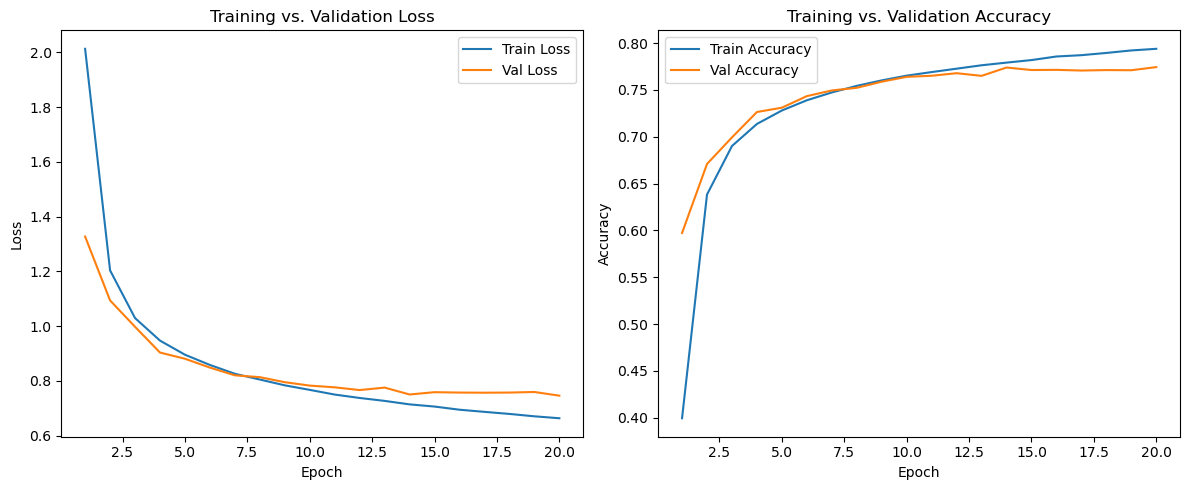

In [23]:
# your code here
import matplotlib.pyplot as plt

# Extract values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<a id="part2"></a>
<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">

Then, evaluate the model on the training and validation sets and print the corresponding loss and accuracy values. You should get a validation accuracy >= 77 if you did everything right.

In [24]:
# your code here
# Evaluate on training data
train_loss, train_accuracy = ViT.evaluate(train_data, verbose=0)
print(f"Training Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.4f}")

# Evaluate on validation data
val_loss, val_accuracy = ViT.evaluate(validation_data, verbose=0)
print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")


Training Loss: 0.6004 - Training Accuracy: 0.8115
Validation Loss: 0.7464 - Validation Accuracy: 0.7743


<a id="part3"></a>
# PART 3 [10 pts]: The Quick, Draw!  Kaggle competition

[Return to contents](#contents)

<a id="part3kaggle"></a>

## CS1090B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/e067286be2c54c078434793659326610). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS1090B Kaggle competition, please see below and also review. The modeling restrictions DOS and DON'TS are outlined in Kaggle Overview page.

**IMPORTANT NOTES ABOUT SCORING**:

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `label` and needs to contain your class predictions (i.e. 'cat', 'tiger' etc) for each corresponding test observation index location. 
- The **public leaderboard** on Kaggle displays your performance on 45% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 55% of the test set.


**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 5 submissions per team per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW5 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW5 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the training and test data downloaded via the "Data" tab of [the CS1090B competition page linked above](#part2data).**

- **Do not** create multiple accounts on Kaggle.



<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

<a id="q3.1"></a>

**3.1.1**  **Kaggle Competition**

Create a model and use it to compete on Kaggle.


**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results.

**Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).
[https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/overview)**

</div>

## Model Considerations 
ViT - already almost 80% accuracy, can just tweak a little past 1st benchmark
CNN Attention Hybrid -- few conv layers then flatten feature maps then MHA (exp. accuracy 80-85%)
**Essentially this is MobileViT**

I will go with the CNN Attention Hybrid. 
1. CNN layers w/ max pooling + dropout: extract important features/signals from images (edges, shapes)
2. Flatten the feature maps so I can pass them in as vectors into the transformer encoder
3. Pass the feature maps into TransformerEncoder to understand global spatial relationships
4. Final Dense Classification head

Notes
I do not need a CLS token to concatenate with the flattened feature maps, which is standard for hybrid models. Instead of using CLS, I just use global average pooling on the attention outputs. This aggregates the outputs into one vector, a vector of logits.
- I do not need positional encoding b/c the CNN preserves and encodes spatial information via receptive fields, maxpooling, and local filters. Once I flatten a CNN feature map, the spatial layout is implicity preserved
- Residual connection, LayerNorm, etc already included in TransformerEncoderBlock

Confusion on residual connection - my question essentially is why doesn't a skip connection nullify the weights in between said skip connection? output = x + f(x) --> why doesn't the model just ignore f(x)? ski pconnections create highway for gradient to flow backward, network can learn f(x) or f(x) can be 0, usually learns combination, The network learns what to add or subtract from the input, not just “skip over it.”. 

In [54]:
# your code here
#Any methods taught in class are valid (e.g., FFNN, CNN, Attention, transfer learning, 
#data augmentation, etc.). Any advanced methods that go beyond the course content must be accompanied 
#by a thorough explanation of how this method works and why it is helpful for this problem.

class CNNWithAttention(tf.keras.Model):
    def __init__(self, num_classes):
        super(CNNWithAttention, self).__init__()
        #first data augmentation
        self.augment = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1)
        ])
        #CNN backbone - (convolutional layer dim 32x32x3, batch norrm, max pooling) x 2
        self.conv1 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPooling2D()

        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.pool2 = tf.keras.layers.MaxPooling2D()

        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.pool3 = tf.keras.layers.MaxPooling2D()

        self.conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.pool4 = tf.keras.layers.MaxPooling2D()

        # self.conv5 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        # self.bn5 = tf.keras.layers.BatchNormalization()
        # self.pool5 = tf.keras.layers.MaxPooling2D()

        #attention -- flatten the CNN feature maps (reshape) into the number of neurons in conv2d layer
        #which is 64. 
        self.flatten_spatial = tf.keras.layers.Reshape((-1, 256))  # (B, H*W, C)
       
        self.encoder_block = TransformerEncoderBlock(
            embed_dim=256,
            attention_dim=256,
            feedforward_dim=128,
            num_heads=8
        )

        # self.encoder_block2 = TransformerEncoderBlock(
        #     embed_dim=256,
        #     attention_dim=256,
        #     feedforward_dim=128,
        #     num_heads=8
        # )
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.dropout = tf.keras.layers.Dropout(0.3)
        #final classification
        self.global_avg = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(num_classes)


    def call(self, inputs):
        x = self.augment(inputs) 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.pool4(x)

        # x = self.conv5(x)
        # x = self.bn5(x)
        # x = self.pool5(x)

        #flatten spatial dims
        x = self.flatten_spatial(x)
        #pass the flattened vector into the transformer encoder block
        x = self.encoder_block(x)
        # x = self.encoder_block2(x)
        x = self.norm(x)
        x = self.dropout(x)
        

        #global avg pooling instead of cls
        x = self.global_avg(x)
        output = self.dense(x)

        return output


In [55]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(10000).batch(256)
validation_data = tf.data.Dataset.from_tensor_slices((test_x, test_y)).shuffle(10000).batch(256)

In [56]:
# your code here
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
#decreased the learning rate from 0.005 to 3e-5
model = CNNWithAttention(num_classes=24)
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

history = model.fit(train_data,validation_data=validation_data,epochs=50,verbose=1, 
                    callbacks = [early_stop])


# ViT.compile(optimizer = optimizer, loss= loss_fn, 
#             metrics = ['accuracy'])

# history = ViT.fit(train_data, validation_data = validation_data, epochs = 20, verbose = 1)

Epoch 1/50
1076/1076 [==============================] - 21s 12ms/step - loss: 2.2474 - accuracy: 0.3589 - val_loss: 1.6348 - val_accuracy: 0.5257
Epoch 2/50
1076/1076 [==============================] - 13s 12ms/step - loss: 1.6145 - accuracy: 0.5262 - val_loss: 1.3127 - val_accuracy: 0.6115
Epoch 3/50
1076/1076 [==============================] - 13s 12ms/step - loss: 1.4009 - accuracy: 0.5867 - val_loss: 1.2111 - val_accuracy: 0.6413
Epoch 4/50
1076/1076 [==============================] - 13s 12ms/step - loss: 1.2670 - accuracy: 0.6268 - val_loss: 1.1209 - val_accuracy: 0.6664
Epoch 5/50
1076/1076 [==============================] - 13s 12ms/step - loss: 1.1745 - accuracy: 0.6504 - val_loss: 1.0639 - val_accuracy: 0.6816
Epoch 6/50
1076/1076 [==============================] - 13s 12ms/step - loss: 1.1083 - accuracy: 0.6707 - val_loss: 1.0415 - val_accuracy: 0.6914
Epoch 7/50
1076/1076 [==============================] - 13s 12ms/step - loss: 1.0566 - accuracy: 0.6855 - val_loss: 0.9454 -

## Edited Hybrid Model W/ Positional Encoding + Custom Transformer Block Function + Deeper Dense Classification Head (FINAL KAGGLE MODEL SUBMISSION)

The inspiration, positional encoding, and custom transformer block functions were derived from my friend, Nai Hola, who helped me greatly in thinking through my roadblocks with the previous model for this kaggle competition. He also proposed a novel idea of cosine decay for learning rate stability, which apparently is better than the lr_plateau attribute we always use. 

In [34]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay
# positional encoding
#even though hybrid models do not need, just going to add one anyway 
class LearnablePositionEncoding(layers.Layer):
    def __init__(self, num_tokens, dim):
        super().__init__()
        self.pos_encoding = self.add_weight(
            "pos_embedding", shape=(1, num_tokens, dim),
            initializer="random_normal", trainable=True
        )

    def call(self, x):
        return x + self.pos_encoding

In [27]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay

In [28]:
#changed num_heads from 4 to 8 and key_dim from 64 to 16
def transformer_block_new(x, num_heads=8, key_dim=16, mlp_dim=256, dropout_rate=0.2):
    # laynorm the input, then apply multi head attention w/ 8 attention heads, then have skip connection
    x1 = layers.LayerNormalization()(x)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x1, x1)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    x2 = layers.Add()([x, attn_output])  # skip connection

    #layernorm the attention embeddings, pass through classification dense head, dropout, classify. 
    x3 = layers.LayerNormalization()(x2)
    mlp_output = layers.Dense(mlp_dim, activation='relu')(x3)
    mlp_output = layers.Dropout(dropout_rate)(mlp_output)
    mlp_output = layers.Dense(x.shape[-1])(mlp_output)
    return layers.Add()([x2, mlp_output])

In [35]:
def build_vit_hybrid_deep_new(input_shape=(28, 28, 1), num_classes=len(classes), num_transformer_blocks=3):
    inputs = layers.Input(shape=input_shape)
    #data augmentation - part of regularization
    #all these methods below are ways to alternate the images
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomFlip("horizontal")(x)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomTranslation(0.1,0.1)(x)
    x = layers.RandomZoom(0.1,0.1)(x)
    x = layers.RandomContrast(0.2)(x)
    
   


    # conv stem -- edited to be deeper and higher capacity 
    # 28x28 → 14x14
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)  
    #14x14 -> 7x7
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)  
    #keep 7x7 and add two more conv layers 
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling2D()(x)  
    # x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling2D()(x) 

    # flatten grid into tokens
    # x = layers.Reshape((9, 64))(x) 3x3, 64 dim
    #final conv output is 7x7x128 so reshape 
    x = layers.Reshape((7*7, 128))(x)
    x = layers.LayerNormalization()(x)
    x = LearnablePositionEncoding(num_tokens=49, dim=128)(x)

    # transformer block
    for _ in range(num_transformer_blocks):
        x = transformer_block_new(x)

    #larger classification head 
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes)(x)  # logits (no activation)

    return models.Model(inputs, outputs)

vit_hybrid_new = build_vit_hybrid_deep_new(input_shape=(28, 28, 1), num_classes=len(classes), num_transformer_blocks=3)

In [36]:
steps_per_epoch = len(train_data)
lr_schedule = CosineDecay(
    initial_learning_rate=0.005,
    decay_steps=20 * steps_per_epoch,  # total training steps
    alpha=1e-5  # final learning rate as a fraction of initial
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

vit_hybrid_new.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history_new = vit_hybrid_new.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

2025-05-03 09:25:59.990635: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 863654400 exceeds 10% of free system memory.


Epoch 1/30


2025-05-03 09:26:04.011021: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-05-03 09:26:05.888185: I external/local_xla/xla/service/service.cc:168] XLA service 0x149a2e70d380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-03 09:26:05.888224: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-05-03 09:26:05.914590: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746278765.994199   16798 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


538/538 [==============================] - 37s 52ms/step - loss: 1.1811 - accuracy: 0.6515 - val_loss: 1.3365 - val_accuracy: 0.6238
Epoch 2/30
538/538 [==============================] - 27s 50ms/step - loss: 0.7388 - accuracy: 0.7845 - val_loss: 0.7055 - val_accuracy: 0.7874
Epoch 3/30
538/538 [==============================] - 27s 50ms/step - loss: 0.6515 - accuracy: 0.8083 - val_loss: 0.8885 - val_accuracy: 0.7411
Epoch 4/30
538/538 [==============================] - 27s 51ms/step - loss: 0.6095 - accuracy: 0.8198 - val_loss: 0.8160 - val_accuracy: 0.7579
Epoch 5/30
538/538 [==============================] - 27s 51ms/step - loss: 0.5800 - accuracy: 0.8277 - val_loss: 0.7587 - val_accuracy: 0.7801
Epoch 6/30
538/538 [==============================] - 27s 51ms/step - loss: 0.5519 - accuracy: 0.8356 - val_loss: 0.5949 - val_accuracy: 0.8187
Epoch 7/30
538/538 [==============================] - 27s 51ms/step - loss: 0.5265 - accuracy: 0.8419 - val_loss: 0.5963 - val_accuracy: 0.8239
Epo


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


**3.1.2**  Plot your model's training accuracy and and any relevant metrics as a function of epochs.




</div>

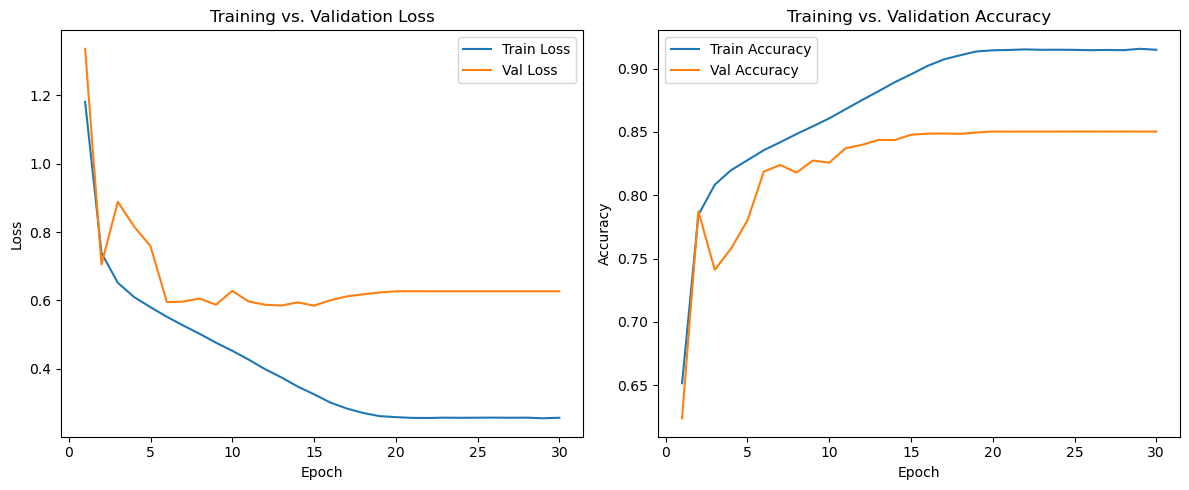

In [37]:
# your code here
import matplotlib.pyplot as plt

# Extract values
train_loss = history_new.history['loss']
val_loss = history_new.history['val_loss']
train_acc = history_new.history['accuracy']
val_acc = history_new.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


**3.1.3**  In a few sentences, describe the various approaches you have taken to improve the performance of your model as well as any observations you might have regarding your training and Kaggle results.


</div>

**APPROACH AND OBSERVATIONS:**

I will bullet the major changes and various approaches I took to improve the performance of my model (as seen above).
1. Positional Encoding: This is crucial because we know the transformer does not have understanding of sequential ordering. While the CNN extacts local features, and the transformer captures long-range dependencies, there is a need  to make sure the trasnformer understands the order of the patches, allowing it to make better decisions.
2. Number of attention heads 4 --> 8: Increasing the number of attention heads allowed for more contextual mappings amongst patch attention embeddings. This increased accuracy by a few percentage points.
3. Data Augmentation: Data augmentation is a must have for achieving better model performance. It enhances machine learning model performance by increasing the diversity and size of the training dataset, which can lead to reduced overfitting, improved generalization, and increased accuracy.
4. Wider MLP heads: In the first model, I had one dense layer with 24 nodes following the attention embedding output. Increasing the MLP head size, starting with Dense(256) to Dense(128) to Dense(24) certainly improved accuracy. It seemed like I was underfitting before.
5. Attending over 49 tokens: Changed the attention of patches from 9 tokens to 49 to increase model capacity. Resulted in improved performance.

In general, the structure of the CNN With Attention Hybrid remained the same and led to increased performance capacity -- convolutional stem, reshape feature maps and vectorize, positional embeddings, transformer blocks (layernorm -> MHA -> skip -> MLP -> skip), globalavg pooling and small FFN head to produce logits. 


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**3.2.1**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS1090B Kaggle Competition](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/) for leaderboard scoring. 

**IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 54,000 predictions, the second column must be named `"label"` and needs to contain your class predictions (i.e. `cat` or `dog` etc.) for each corresponding test observation index location. A sample submission file is provided on [Kaggle](https://www.kaggle.com/competitions/cs-1090-b-hw-5-contest-2025/data?select=sample_submission.csv)
</div>

In [38]:
# your code here
data_file = "test.csv"
df = pd.read_csv(data_file)
id_to_label = {idx: label for label, idx in label_to_id.items()}

In [39]:
X_raw = df.drop(columns=['id']).astype('float32') / 255.0

# id
ids = df['id'].astype(int).values

# Reshape images
X_test = X_raw.values.reshape(-1, 28, 28, 1)

In [40]:
y_pred_probs = vit_hybrid_new.predict(X_test)
y_pred_labels_id = np.argmax(y_pred_probs, axis = 1)


y_pred_labels_str = [id_to_label[idx] for idx in y_pred_labels_id]

1688/1688 [==============================] - 8s 4ms/step


In [41]:
submission = pd.DataFrame({
    "id": ids,
    "label": y_pred_labels_str
})

# Save CSV
submission.to_csv("submission.csv", index=False)


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


**3.2.2**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**


PavlosCoinCEO


<!-- BEGIN QUESTION -->


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
<b>3.3 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

The kaggle competition was by far the most challenging aspect of this homework. I spent two full days trying ot build a model that would achieve accuracy above 80%. It was frustrating because ChatGPT kept telling me my original CNN with attention model was perfect; it was not until further examination, collaboration with friends, and exploration into different regularization techniques that I was able to pass the first benchmark with the new model. 

In [42]:
hours_spent_on_hw = 24 # np.inf

In [43]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 51.28 minutes for this notebook to run


**This concludes HW5... the final CS 1090B HW! Thank you!**